# Programming for Data Science and Artificial Intelligence

## Classification - AdaBoost

### Readings:
- [GERON] Ch7
- [VANDER] Ch5
- [HASTIE] Ch16
- https://scikit-learn.org/stable/modules/ensemble.html

In [1]:
from sklearn.model_selection import train_test_split
from sklearn.datasets import make_moons
import numpy as np
import matplotlib.pyplot as plt

## AdaBoost

**AdaBoost** is a boosting algorithm that try to take a weak classifier on top of one another, **boosting** the overall performance. AdaBoost is extremely simple to use and implement, and often gives very effective results. There is tremendous flexibility in the choice of weak classifier as well. Anyhow, Decision Tree with <code>max_depth=1</code> and <code>max_leaf_nodes=2</code> are often used (also known as **stump**)

<img src = "../../Figures/ada.png" />

Suppose we are given training data ${(\mathbf{x_i}, y_i)}$, where $\mathbf{x_i} \in \mathbb{R}^n$ and $y_i \in \{-1, 1\}$.  And we have $S$ number of weak classifiers, denoted $h_s(x)$.  For each classifier, we define $\alpha_s$ as the *voting power* of the classifier $h_s(x)$. Then, the hypothesis function is based on a linear combination of the weak classifier and is written as:

$$
\begin{aligned}
h(x) & = \text{sign}\big(\alpha_1h_1(x) + \alpha_2h_2(x) + \cdots + \alpha_sh_s(x) )\big) \\
& = \text{sign}\big(\sum_{s=1}^{S}\alpha_sh_s(x)\big)
\end{aligned}
$$

Our job is to find the optimal $\alpha_s$, so we can know which classifier we should give more weightage (i.e., believe more) in our hypothesis function since their accuracy is relatively better compared to other classifiers.  To get this alpha, we should define what is "good" classifier.  This is simple, since good classifier should simply has the minimum weighted errors as:

$$\epsilon_s = \sum_{i=1}^m w_i^{s}I(h_s(x_i) \neq y_i) $$

in which the weights are initialized in the beginning as

$$w_i^{(1)} = \frac{1}{m}$$ 

For example, given $h(x)$ as <code>yhat</code> and <code>y</code> as the real y, we get:

In [2]:
yhat = np.array([-1,  1, -1, 1, 1]) #(h_s(x))
y    = np.array([ 1,  1,  1, 1, 1])
(yhat != y).sum()

2

We can calculate its weighted errors

In [3]:
m = 5 #since we have five samples

#initially, we set our weight to 1/m
W = np.full(m, 1/m)
print(W)

[0.2 0.2 0.2 0.2 0.2]


In [4]:
err = W[(yhat != y)].sum()
print(err.round(2))

0.4


If we try to change our weight bigger for the first one, you will see that the final error is enlarged.

In [5]:
W = np.array([0.7, 0.2, 0.2, 0.2, 0.2])
err = W[(yhat != y)].sum()
print(err.round(2))

0.9


After we perform the first classifier, we update the weights of the samples using this formula:

$$w_i^{(s+1)} = \frac{w_i^{(s)}e^{ -\alpha_sh_s(\mathbf{x_i}) y_i}}{{\displaystyle\sum_{i=1}^m w_i^{s}}} $$

where $\alpha_s$ is:

$$\alpha_s = \frac{1}{2}\ln\frac{1-\epsilon_s}{\epsilon_s}$$

First, to see why this formula works, let's plot alpha against errors:

"\nHigher the error, lower is alpha, which means we don't trust that classifier.  And vice versa.\n"

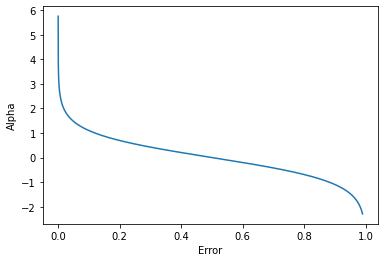

In [6]:
err = np.linspace(0, 0.99, 10000) #select only 0.99 not 1 because np.log(1-1=0) = inf
err = err + 0.00001 #prevent divide by zero
a_j = np.log ((1 - err) / err) * 0.5

plt.plot(err, a_j)
plt.xlabel("Error")
plt.ylabel("Alpha")

'''
Higher the error, lower is alpha, which means we don't trust that classifier.  And vice versa.
'''

Second, let's look at the update rule on why it works:

$$w_i^{(s+1)} = \frac{w_i^{(s)}e^{ -\alpha_sh_s(\mathbf{x_i}) y_i}}{{\displaystyle\sum_{i=1}^m w_i^{s}}} $$

In [7]:
#recall
print(y, yhat)

[1 1 1 1 1] [-1  1 -1  1  1]


In [8]:
#recall the err
W = np.full(m, 1/m)
err = W[(yhat != y)].sum()
print(err)

0.4


In [9]:
#calculate the a_j
a_j = np.log ((1 - err) / err) * 0.5
print(a_j)

0.2027325540540821


In [10]:
yhat * y

array([-1,  1, -1,  1,  1])

In [11]:
-a_j * yhat * y

array([ 0.20273255, -0.20273255,  0.20273255, -0.20273255, -0.20273255])

In [12]:
np.exp(-a_j * yhat * y)  #notice the scalar is bigger for incorrectly classified sample

array([1.22474487, 0.81649658, 1.22474487, 0.81649658, 0.81649658])

In [13]:
W = (W * np.exp(-a_j * yhat * y))/sum(W)
print(W)

[0.24494897 0.16329932 0.24494897 0.16329932 0.16329932]


## Putting everything together:

1. Loop through all features, threshold, and polarity, identify the best stump which has lowest weighted errors.

2. Calculate alpha of the first classifier

$$\alpha_s = \frac{1}{2}ln\frac{1-\epsilon_s}{\epsilon_s}$$

3. Exaggerate the incorrect samples using

$$w_i^{(s+1)} = \frac{w_i^{(s)}e^{ -\alpha_sh_s(\mathbf{x_i}) y_i}}{{\displaystyle\sum_{i=1}^m w_i^{s}}} $$

4. Repeat 1.

5. We stop 1-4 using max_iter, early stopping, or number of classifiers.

6. To predict, we use the hypothesis function:

$$ 
  H(x) = \text{sign}\big(\sum_{s=1}^{S}\alpha_sh_s(x)\big)
$$

## AdaBoost

### Scratch

In [14]:
from sklearn.datasets import make_classification

X, y = make_classification(n_samples=500, random_state=1)
y = np.where(y==0,-1,1)  #change our y to be -1 if it is 0, otherwise 1

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42)

In [15]:
from sklearn.metrics import accuracy_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report

m = X_train.shape[0]
S = 20
stump_params = {'max_depth': 1, 'max_leaf_nodes': 2}
models = [DecisionTreeClassifier(**stump_params) for _ in range(S)]

#initially, we set our weight to 1/m
W = np.full(m, 1/m)

#keep collection of a_j
a_js = np.zeros(S)

for j, model in enumerate(models):
    
    #train weak learner
    model.fit(X_train, y_train, sample_weight = W)
    
    #compute the errors
    yhat = model.predict(X_train) 
    err = W[(yhat != y_train)].sum()
        
    #compute the predictor weight a_j
    #if predictor is doing well, a_j will be big
    a_j = np.log ((1 - err) / err) / 2
    a_js[j] = a_j
    
    #update sample weight; divide sum of W to normalize
    W = (W * np.exp(-a_j * y_train * yhat)) 
    W = W / sum (W)
    
        
#make weighted predictions
Hx = 0
for i, model in enumerate(models):
    yhat = model.predict(X_test)
    Hx += a_js[i] * yhat
    
yhat = np.sign(Hx)

print(classification_report(y_test, yhat))

              precision    recall  f1-score   support

          -1       0.96      0.97      0.97        79
           1       0.97      0.96      0.96        71

    accuracy                           0.97       150
   macro avg       0.97      0.97      0.97       150
weighted avg       0.97      0.97      0.97       150



### Sklearn 

Sklearn implements AdaBoost using SAMME which stands for Stagewise Additive Modeling using a Multiclass Exponential Loss Function.

The following code trains an AdaBoost classifier based on 200 Decision stumps.  A Decision stump is basically a Decision Tree with max_depth=1.  This is the default base estimator of AdaBoostClassifier class:

In [16]:
from sklearn.ensemble import AdaBoostClassifier

#SAMME.R - a variant of SAMME which relies on class probabilities 
#rather than predictions and generally performs better
ada_clf = AdaBoostClassifier(
    DecisionTreeClassifier(max_depth=1), n_estimators=200,
    learning_rate=0.5, random_state=42)
ada_clf.fit(X_train, y_train)
y_pred = ada_clf.predict(X_test)
print("Ada score: ", accuracy_score(y_test, y_pred))

Ada score:  0.9666666666666667


### ===Task===

Your work: Let's modify the above scratch code:
- Notice that if <code>err</code> = 0, then $\alpha$ will be undefined, thus attempt to fix this by adding some very small value to the lower term
- Notice that sklearn version of AdaBoost has a parameter <code>learning_rate</code>.  This is in fact the $\frac{1}{2}$ in front of the $\alpha$ calculation.  Attempt to change this $\frac{1}{2}$ into a parameter called <code>eta</code>, and try different values of it and see whether accuracy is improved.  Note that sklearn default this value to 1.
- Observe that we are actually using sklearn DecisionTreeClassifier.  If we take a look at it closely, it is actually using weighted gini index, instead of weighted errors that we learn above.   Attempt to write your own class of <code>class Stump</code> that actually uses weighted errors, instead of weighted gini index
- Put everything into a class